In [103]:
!pip install xgboost


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 36.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 4.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 kB 8.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 4.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.2 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2019.3
    Uninstalling pytz-2019.3:
      Successfully uninstalled pytz-2019.3
  Attempting uninstall: tqdm
    Found exis

In [3]:
import sys
import os

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/notebooks/services"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import importlib
import pandas as pd
import numpy as np
from datetime import datetime
from initial_tests.xgbr_test import test_xgbr
from model_training.tune_xgboost_regression import tune_xgbr
from model_training.tune_isolation_forest import tune_iforest
from xgboost import plot_importance
from matplotlib import pyplot
from xgboost import XGBRegressor
from model_selection.src import main as model_selection_svc
from artificial_anomaly_tests.aa_tests import artificial_anomaly_test_xgb
from sklearn.ensemble import IsolationForest
import pickle
import ast

/root/HAIP/notebooks
['/root/HAIP/notebooks/op-10', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/root/HAIP/notebooks/services', '/root/HAIP/notebooks/config', '/root/HAIP/notebooks']


In [5]:
settings = {
    # Measure specific options
    "SHAREPOINT_MEASURE_DIR": "OP-10 Clean",
    "MEASURE_SPECIFIC_FILENAME": "OP-10.csv",
    "FULL_MEASURE_S3_PREFIX": "OP-10",
    "filter_measure": "OP_10", # make sure this is _ not -
    
    # Feature Engineering options
    "save_modeling_dataset_path": '/root/HAIP/notebooks/op-10/data/OP-10.csv',
    "backfill_prov_mean": True, # set to false to not backfill prov mean
    "backfill_lag": True, # set to false to not backfill lag
    "lag_to_add": 2, # add lag1/lag2
}

# Need to set up Feature Engineering for TEC

In [6]:
modeling_df = pd.read_csv("data/OP-10-no-backfill.csv").drop(columns = ['provider_id','lag2']).dropna()
xgbr_modeling_df = pd.read_csv("data/OP-10-no-backfill.csv").drop(columns = ['provider_id','lag2'])

In [7]:
modeling_df

,score,lag1,year,quarter,lag_diff,prov_mean,prov_mean_diff
1,6.5,4.6,2014,2,1.9,4.600000,1.900000
2,6.4,6.5,2015,2,-0.1,5.550000,0.850000
3,9.0,6.4,2016,2,2.6,5.833333,3.166667
4,6.5,9.0,2017,2,-2.5,6.625000,-0.125000
5,8.0,6.5,2018,2,1.5,6.600000,1.400000
...,...,...,...,...,...,...,...
29089,7.5,6.6,2019,2,0.9,4.150000,3.350000
29090,1.6,7.5,2019,4,-5.9,5.266667,-3.666667
29092,12.6,16.1,2019,2,-3.5,16.100000,-3.500000
29093,8.7,12.6,2019,4,-3.9,14.350000,-5.650000


In [8]:
xgbr_modeling_df = xgbr_modeling_df[~((xgbr_modeling_df['year'] == 2019) & (xgbr_modeling_df['quarter'] == 4))].dropna()
xgbr_modeling_df = xgbr_modeling_df.drop(columns = ['lag_diff', 'prov_mean_diff'])
xgbr_modeling_df

,score,lag1,year,quarter,prov_mean
1,6.5,4.6,2014,2,4.600000
2,6.4,6.5,2015,2,5.550000
3,9.0,6.4,2016,2,5.833333
4,6.5,9.0,2017,2,6.625000
5,8.0,6.5,2018,2,6.600000
...,...,...,...,...,...
29082,0.2,0.8,2018,2,1.000000
29086,63.2,69.2,2018,2,69.200000
29088,6.6,1.7,2018,2,1.700000
29089,7.5,6.6,2019,2,4.150000


In [9]:
xgbr_modeling_df

,score,lag1,year,quarter,prov_mean
1,6.5,4.6,2014,2,4.600000
2,6.4,6.5,2015,2,5.550000
3,9.0,6.4,2016,2,5.833333
4,6.5,9.0,2017,2,6.625000
5,8.0,6.5,2018,2,6.600000
...,...,...,...,...,...
29082,0.2,0.8,2018,2,1.000000
29086,63.2,69.2,2018,2,69.200000
29088,6.6,1.7,2018,2,1.700000
29089,7.5,6.6,2019,2,4.150000


In [10]:
xgbr_model, cv_rmse = test_xgbr(xgbr_modeling_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [13]:
cv_rmse

4.198914192739643

In [13]:
model = XGBRegressor()
X = xgbr_modeling_df.drop(columns = ['score'])
y = xgbr_modeling_df[['score']]
model.fit(X, y)
yhat = model.predict(X)

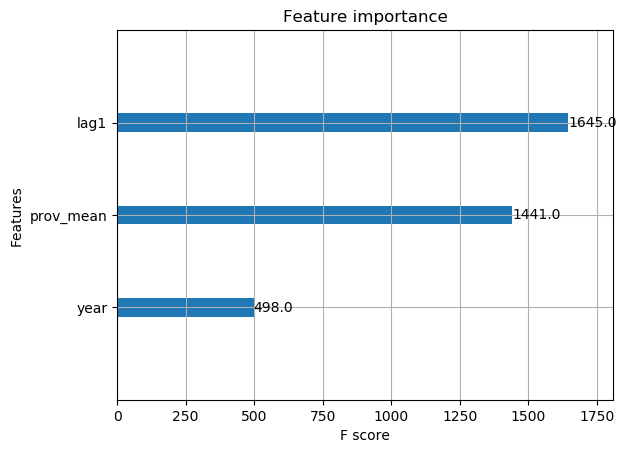

In [14]:
plot_importance(model)
pyplot.show()

In [11]:
xgbr_selected_features = ['lag1', 'prov_mean']

eta = [[0.05, 0.1, 0.2, 0.3]]
gamma = [range(0,2)]
max_depth = [range(5,9)]
min_child_weight = [range(3,9)]
subsample = [[1]]
alpha = [[0,1,2]]

parameters_dict = {'eta': eta, 
                      'gamma': gamma,
                      'max_depth': max_depth,
                      'min_child_weight': min_child_weight,
                      'subsample': subsample,
                      'alpha': alpha}

In [12]:
# Feature Selection
final_xgbr_modeling_df = xgbr_modeling_df[xgbr_selected_features +['score']]
final_xgbr_modeling_df

,lag1,prov_mean,score
1,4.6,4.600000,6.5
2,6.5,5.550000,6.4
3,6.4,5.833333,9.0
4,9.0,6.625000,6.5
5,6.5,6.600000,8.0
...,...,...,...
29082,0.8,1.000000,0.2
29086,69.2,69.200000,63.2
29088,1.7,1.700000,6.6
29089,6.6,4.150000,7.5


In [18]:
xgbr_save_path = './model_runs/xgboost_regression'
current_date = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")

xgbr_candidates = tune_xgbr(xgbr_modeling_df,
                            'score',
                            parameters_dict,
                            xgbr_save_path,
                            current_date)

Fitting 50 folds for each of 576 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3800 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4536 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5336 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 8120 tasks      |

[0]	validation_0-rmse:11.05560
[1]	validation_0-rmse:10.11218
[2]	validation_0-rmse:9.27601
[3]	validation_0-rmse:8.53637
[4]	validation_0-rmse:7.88519
[5]	validation_0-rmse:7.31179
[6]	validation_0-rmse:6.81172
[7]	validation_0-rmse:6.36932
[8]	validation_0-rmse:5.98278
[9]	validation_0-rmse:5.65062
[10]	validation_0-rmse:5.36665
[11]	validation_0-rmse:5.12408
[12]	validation_0-rmse:4.92003
[13]	validation_0-rmse:4.74586
[14]	validation_0-rmse:4.59534
[15]	validation_0-rmse:4.47202
[16]	validation_0-rmse:4.36771
[17]	validation_0-rmse:4.27868
[18]	validation_0-rmse:4.20894


[Parallel(n_jobs=-1)]: Done 28800 out of 28800 | elapsed: 12.8min finished


[19]	validation_0-rmse:4.14990
[20]	validation_0-rmse:4.10063
[21]	validation_0-rmse:4.06165
[22]	validation_0-rmse:4.02619
[23]	validation_0-rmse:3.99943
[24]	validation_0-rmse:3.97829
[25]	validation_0-rmse:3.95445
[26]	validation_0-rmse:3.93756
[27]	validation_0-rmse:3.92328
[28]	validation_0-rmse:3.91267
[29]	validation_0-rmse:3.90194
[30]	validation_0-rmse:3.89430
[31]	validation_0-rmse:3.88911
[32]	validation_0-rmse:3.88286
[33]	validation_0-rmse:3.87830
[34]	validation_0-rmse:3.87664
[35]	validation_0-rmse:3.87222
[36]	validation_0-rmse:3.87291
[37]	validation_0-rmse:3.86685
[38]	validation_0-rmse:3.86457
[39]	validation_0-rmse:3.86567
[40]	validation_0-rmse:3.86471
[41]	validation_0-rmse:3.87177
[42]	validation_0-rmse:3.87357
[43]	validation_0-rmse:3.87941
[44]	validation_0-rmse:3.87983
[45]	validation_0-rmse:3.87870
[46]	validation_0-rmse:3.87987
[47]	validation_0-rmse:3.88100
[48]	validation_0-rmse:3.88194
[49]	validation_0-rmse:3.88310
[50]	validation_0-rmse:3.88156
[51]	val

In [12]:
modeling_df.describe()

,score,lag1,year,quarter,lag_diff,prov_mean,prov_mean_diff
count,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000
mean,7.413763,8.661273,2016.850034,2.250413,-1.247510,9.732317,-2.318554
std,8.414690,9.470437,1.798227,0.661920,4.511939,10.353490,6.122558
min,0.100000,0.100000,2014.000000,2.000000,-75.400000,0.100000,-75.400000
25%,2.700000,3.400000,2015.000000,2.000000,-2.500000,3.780000,-3.500000
50%,5.100000,5.900000,2017.000000,2.000000,-0.500000,6.300000,-1.000000
75%,8.800000,10.000000,2019.000000,2.000000,0.800000,11.250000,0.550000
max,92.000000,96.400000,2019.000000,4.000000,44.600000,96.400000,44.600000


In [22]:
# Features to include
features_included = [['lag_diff', 'prov_mean_diff']]

# n_estimators: int, default=100
#The number of base estimators in the ensemble.
n_estimators_list = [50,100,200,300]

# max_samples: “auto”, int or float, default=”auto”
# The number of samples to draw from X to train eachz base estimator.
max_samples_list  = ['auto', 200, 175, 128]

# max_features: int or float, default=1.0
# The number of features to draw from X to train each base estimator.
max_features_list  = [1]

# bootstrap: bool, default=False
# If True, individual trees are fit on random subsets of the training data sampled with replacement. If False, sampling without replacement is performed.
bootstrap_list  = [False, True]

parameters_dict = {'features_included': features_included,
                      'n_estimators': n_estimators_list, 
                      'max_samples': max_samples_list,
                      'max_features': max_features_list,
                      'bootstrap': bootstrap_list}

In [23]:
iforest_save_path = './model_runs/isolation_forest'
current_date = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")

In [24]:
iforest_candidates = tune_iforest(modeling_df, 
                                  parameters_dict, 
                                  iforest_save_path,
                                  current_date)

KeyboardInterrupt: 

# Modeling Selection

In [15]:
xg_boost_regression_settings = {
    "model_run_data_path": '/root/HAIP/notebooks/op-10/xgboost-regression/xgbr_tuning_results_run_2022-11-08-20h37m.csv',    
    "model_type": "XGBRegression"
}


settings = {**settings, **xg_boost_regression_settings}

In [16]:
model_selector = model_selection_svc.get_model_selector(settings)
model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
2,-5.8555,0.3707,1,0,0.3,1,6,6,1,"{'alpha': 0, 'eta': 0.3, 'gamma': 1, 'max_dept..."
0,-5.8596,0.3714,2,0,0.3,0,6,6,1,"{'alpha': 0, 'eta': 0.3, 'gamma': 0, 'max_dept..."
4,-5.8647,0.3726,3,1,0.3,0,6,6,1,"{'alpha': 1, 'eta': 0.3, 'gamma': 0, 'max_dept..."
6,-5.8648,0.3726,4,1,0.3,1,6,6,1,"{'alpha': 1, 'eta': 0.3, 'gamma': 1, 'max_dept..."
5,-5.8660,0.3694,5,1,0.3,0,7,6,1,"{'alpha': 1, 'eta': 0.3, 'gamma': 0, 'max_dept..."
1,-5.8669,0.3795,6,0,0.3,0,7,6,1,"{'alpha': 0, 'eta': 0.3, 'gamma': 0, 'max_dept..."
3,-5.8679,0.3791,7,0,0.3,1,7,6,1,"{'alpha': 0, 'eta': 0.3, 'gamma': 1, 'max_dept..."
7,-5.8683,0.3717,8,1,0.3,1,7,6,1,"{'alpha': 1, 'eta': 0.3, 'gamma': 1, 'max_dept..."


In [17]:
selected_model_index = 2
xgbr_final_parameters = model_selector.get_candidate_model_params_by_index(selected_model_index)

In [18]:
xgbr_final_parameters

{'alpha': 0,
 'eta': 0.3,
 'gamma': 1,
 'max_depth': 6,
 'min_child_weight': 6,
 'subsample': 1}

In [19]:
xgbr_final_model = XGBRegressor(**xgbr_final_parameters, random_state = 42)
X = final_xgbr_modeling_df.drop(columns = 'score')
y = final_xgbr_modeling_df[['score']]
xgbr_final_model.fit(X, y)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

In [20]:
xgbr_save_path = './xgboost-regression/xgbr_model_final.pkl'

with open(xgbr_save_path, 'wb') as f:
    pickle.dump(xgbr_final_model, f)

In [21]:
final_xgbr_modeling_df.describe()

,lag1,prov_mean,score
count,21694.000000,21694.000000,21694.000000
mean,8.927086,9.901452,8.159450
std,9.883479,10.711228,8.708054
min,0.100000,0.100000,0.100000
25%,3.400000,3.720000,3.300000
50%,5.900000,6.300000,5.700000
75%,10.300000,11.400000,9.500000
max,96.400000,96.400000,92.000000


In [22]:
xgbr_aat_results = artificial_anomaly_test_xgb(model = xgbr_final_model, 
                            model_data = final_xgbr_modeling_df,
                            selected_features = xgbr_selected_features,
                            shift_range = np.arange(4,11),
                            threshold_range = range(1,10))

In [23]:
xgbr_aat_results

,Threshold,AUROC
2,3,0.840143
3,4,0.833643
1,2,0.802357
4,5,0.796286
5,6,0.750286
6,7,0.702429
0,1,0.687286
7,8,0.648071
8,9,0.601143


In [24]:
# Final Fitting

In [25]:
xgbr_full_df = modeling_df.copy()

In [26]:
xgbr_full_df

,score,lag1,year,quarter,lag_diff,prov_mean,prov_mean_diff
1,6.5,4.6,2014,2,1.9,4.600000,1.900000
2,6.4,6.5,2015,2,-0.1,5.550000,0.850000
3,9.0,6.4,2016,2,2.6,5.833333,3.166667
4,6.5,9.0,2017,2,-2.5,6.625000,-0.125000
5,8.0,6.5,2018,2,1.5,6.600000,1.400000
...,...,...,...,...,...,...,...
29089,7.5,6.6,2019,2,0.9,4.150000,3.350000
29090,1.6,7.5,2019,4,-5.9,5.266667,-3.666667
29092,12.6,16.1,2019,2,-3.5,16.100000,-3.500000
29093,8.7,12.6,2019,4,-3.9,14.350000,-5.650000


In [27]:
xgbr_final_predictions = xgbr_final_model.predict(xgbr_full_df[xgbr_selected_features])
xgbr_full_df['xbgr_pred_score'] = xgbr_final_predictions

In [28]:
xgbr_full_df['xgbr_score_diff'] = xgbr_full_df['score'] - xgbr_final_predictions

In [29]:
xgbr_full_df['xgbr_outlier_pred'] = abs(xgbr_full_df['xgbr_score_diff']) > 4

In [30]:
xgbr_full_df.query('(year == 2019) & (quarter == 4)')['xgbr_outlier_pred'].value_counts()

False    1674
True     1431
Name: xgbr_outlier_pred, dtype: int64

In [31]:
xgbr_full_df[['xgbr_outlier_pred']].value_counts()

xgbr_outlier_pred
False                20538
True                  4261
dtype: int64

In [32]:
if_settings = {
    "model_run_data_path": './model_runs/isolation_forest/tuning_results_run_2022-11-11-14h47m.csv',    
    "model_type": "Isolation Forest"
}

settings = {**settings, **if_settings}

In [33]:
model_selector = model_selection_svc.get_model_selector(settings)
model_selector.get_top_models()

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
0,False,"[lag_diff, prov_mean_diff]",1,auto,50,1,0.8514,0.7732,0.7679,0.7620,0.7563,0.7464,0.7387,0.7323,0.7226,0.7139,0.7050,0.6967,0.6882,0.6812,0.6742,0.6655,0.6571
7,False,"[lag_diff, prov_mean_diff]",1,200,300,8,0.8488,0.7692,0.7638,0.7573,0.7497,0.7423,0.7339,0.7246,0.7150,0.7052,0.6949,0.6846,0.6735,0.6614,0.6486,0.6364,0.6217
16,True,"[lag_diff, prov_mean_diff]",1,auto,50,17,0.8480,0.7655,0.7602,0.7497,0.7403,0.7313,0.7217,0.7139,0.7051,0.6966,0.6874,0.6755,0.6675,0.6610,0.6541,0.6461,0.6364
23,True,"[lag_diff, prov_mean_diff]",1,200,300,24,0.8477,0.7683,0.7626,0.7568,0.7482,0.7403,0.7319,0.7236,0.7143,0.7043,0.6944,0.6839,0.6724,0.6605,0.6484,0.6362,0.6215
8,False,"[lag_diff, prov_mean_diff]",1,175,50,9,0.8474,0.7759,0.7726,0.7666,0.7611,0.7532,0.7461,0.7402,0.7298,0.7215,0.7109,0.6989,0.6849,0.6725,0.6614,0.6517,0.6417
3,False,"[lag_diff, prov_mean_diff]",1,auto,300,4,0.8473,0.7650,0.7601,0.7530,0.7457,0.7351,0.7273,0.7181,0.7089,0.6994,0.6908,0.6822,0.6730,0.6628,0.6526,0.6403,0.6257
28,True,"[lag_diff, prov_mean_diff]",1,128,50,29,0.8472,0.7781,0.7757,0.7719,0.7671,0.7604,0.7532,0.7440,0.7350,0.7277,0.7176,0.7078,0.6992,0.6794,0.6717,0.6576,0.6462
27,True,"[lag_diff, prov_mean_diff]",1,175,300,28,0.8469,0.7706,0.7668,0.7606,0.7537,0.7447,0.7362,0.7290,0.7206,0.7117,0.7022,0.6919,0.6811,0.6697,0.6577,0.6443,0.6313
24,True,"[lag_diff, prov_mean_diff]",1,175,50,25,0.8468,0.7767,0.7740,0.7687,0.7613,0.7541,0.7450,0.7385,0.7283,0.7192,0.7108,0.6982,0.6843,0.6719,0.6600,0.6499,0.6418
25,True,"[lag_diff, prov_mean_diff]",1,175,100,26,0.8467,0.7738,0.7717,0.7675,0.7603,0.7530,0.7452,0.7388,0.7301,0.7223,0.7141,0.7012,0.6861,0.6738,0.6618,0.6490,0.6367


In [34]:
iforest_final_parameters = model_selector.get_candidate_model_params_by_index(1)
iforest_final_parameters
#iforest_modeling_df = modeling_df[iforest_final_parameters['features_included']]
iforest_modeling_df = modeling_df[['lag_diff','prov_mean_diff']]
iforest_final_parameters.pop('features_included')
iforest_modeling_df

,lag_diff,prov_mean_diff
1,1.9,1.900000
2,-0.1,0.850000
3,2.6,3.166667
4,-2.5,-0.125000
5,1.5,1.400000
...,...,...
29089,0.9,3.350000
29090,-5.9,-3.666667
29092,-3.5,-3.500000
29093,-3.9,-5.650000


# Final Fit

In [35]:
xgbr_final_parameters

{'alpha': 0,
 'eta': 0.3,
 'gamma': 1,
 'max_depth': 6,
 'min_child_weight': 6,
 'subsample': 1}

In [36]:
xgbr_final_parameters

{'alpha': 0,
 'eta': 0.3,
 'gamma': 1,
 'max_depth': 6,
 'min_child_weight': 6,
 'subsample': 1}

In [37]:
rng = np.random.RandomState(42)

if_model = IsolationForest(
    random_state = rng,
    **iforest_final_parameters,
    n_jobs = -1)

In [38]:
if_model.fit(iforest_modeling_df)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples='auto', n_estimators=100, n_jobs=-1,
                random_state=RandomState(MT19937) at 0x7F1E124A17C0, verbose=0,
                warm_start=False)

In [39]:
iforest_anomaly_scores = if_model.score_samples(iforest_modeling_df) * -1

In [40]:
iforest_anomaly_scores

array([0.44321861, 0.38736151, 0.47072023, ..., 0.43494145, 0.45878292,
       0.46434229])

In [41]:
iforest_full_df = modeling_df.copy()

In [42]:
iforest_full_df['iforest_score'] = iforest_anomaly_scores
iforest_full_df['iforest_pred'] = iforest_anomaly_scores > 0.5

In [43]:
iforest_full_df['iforest_pred'].value_counts()

False    21096
True      3703
Name: iforest_pred, dtype: int64

In [40]:
iforest_save_path = './isolation-forest/iforest_model_final.pkl'

with open(iforest_save_path, 'wb') as f:
    pickle.dump(if_model, f)

# Ensemble Model

In [44]:
ensemble_modeling_df = modeling_df.copy()
ensemble_modeling_df = ensemble_modeling_df.drop(columns = ['lag_diff','prov_mean_diff'])
ensemble_modeling_df['iforest_score'] = iforest_anomaly_scores
ensemble_modeling_df = ensemble_modeling_df[~((ensemble_modeling_df['year'] == 2019) & (ensemble_modeling_df['quarter'] == 4))].dropna()
ensemble_modeling_df

,score,lag1,year,quarter,prov_mean,iforest_score
1,6.5,4.6,2014,2,4.600000,0.443219
2,6.4,6.5,2015,2,5.550000,0.387362
3,9.0,6.4,2016,2,5.833333,0.470720
4,6.5,9.0,2017,2,6.625000,0.401492
5,8.0,6.5,2018,2,6.600000,0.422357
...,...,...,...,...,...,...
29082,0.2,0.8,2018,2,1.000000,0.385474
29086,63.2,69.2,2018,2,69.200000,0.492800
29088,6.6,1.7,2018,2,1.700000,0.563541
29089,7.5,6.6,2019,2,4.150000,0.444184


In [45]:
ensemble_model, cv_rmse = test_xgbr(ensemble_modeling_df)
ensemble_model = XGBRegressor()
X = ensemble_modeling_df.drop(columns = ['score'])
y = ensemble_modeling_df[['score']]
ensemble_model.fit(X, y)
yhat = ensemble_model.predict(X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

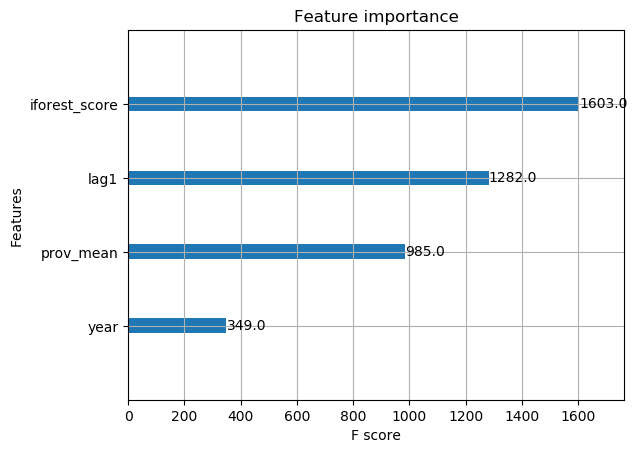

In [43]:
plot_importance(ensemble_model)
pyplot.show()

In [46]:
ensemble_selected_features = ['iforest_score','lag1', 'prov_mean']

eta = [[0.05, 0.1, 0.2, 0.3]]
gamma = [range(0,2)]
max_depth = [range(5,9)]
min_child_weight = [range(3,9)]
subsample = [[1]]
alpha = [[0,1,2]]

parameters_dict = {'eta': eta, 
                      'gamma': gamma,
                      'max_depth': max_depth,
                      'min_child_weight': min_child_weight,
                      'subsample': subsample,
                      'alpha': alpha}

In [81]:
# Feature Selection
final_ensemble_modeling_df = ensemble_modeling_df[ensemble_selected_features +['score']]
final_ensemble_modeling_df

,iforest_score,lag1,prov_mean,score
1,0.443219,4.6,4.600000,6.5
2,0.387362,6.5,5.550000,6.4
3,0.470720,6.4,5.833333,9.0
4,0.401492,9.0,6.625000,6.5
5,0.422357,6.5,6.600000,8.0
...,...,...,...,...
29082,0.385474,0.8,1.000000,0.2
29086,0.492800,69.2,69.200000,63.2
29088,0.563541,1.7,1.700000,6.6
29089,0.444184,6.6,4.150000,7.5


In [54]:
ensemble_save_path = './model_runs/xgbr-ensemble'
current_date = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")

ensemble_candidates = tune_xgbr(final_ensemble_modeling_df,
                                'score',
                                parameters_dict,
                                ensemble_save_path,
                                current_date)

Fitting 50 folds for each of 576 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2400 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3680 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5216 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6080 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7008 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8000 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9056 tasks      |

[0]	validation_0-rmse:11.55721
[1]	validation_0-rmse:11.03187
[2]	validation_0-rmse:10.53589
[3]	validation_0-rmse:10.06388
[4]	validation_0-rmse:9.61932
[5]	validation_0-rmse:9.19460
[6]	validation_0-rmse:8.79338
[7]	validation_0-rmse:8.42064
[8]	validation_0-rmse:8.06415
[9]	validation_0-rmse:7.72552
[10]	validation_0-rmse:7.40618
[11]	validation_0-rmse:7.10120


[Parallel(n_jobs=-1)]: Done 28800 out of 28800 | elapsed:  9.3min finished


[12]	validation_0-rmse:6.81221
[13]	validation_0-rmse:6.54423
[14]	validation_0-rmse:6.28674
[15]	validation_0-rmse:6.04970
[16]	validation_0-rmse:5.82776
[17]	validation_0-rmse:5.61728
[18]	validation_0-rmse:5.41787
[19]	validation_0-rmse:5.23025
[20]	validation_0-rmse:5.05453
[21]	validation_0-rmse:4.88930
[22]	validation_0-rmse:4.73652
[23]	validation_0-rmse:4.59307
[24]	validation_0-rmse:4.45677
[25]	validation_0-rmse:4.33153
[26]	validation_0-rmse:4.21468
[27]	validation_0-rmse:4.10341
[28]	validation_0-rmse:3.99936
[29]	validation_0-rmse:3.90432
[30]	validation_0-rmse:3.81273
[31]	validation_0-rmse:3.72591
[32]	validation_0-rmse:3.64781
[33]	validation_0-rmse:3.57800
[34]	validation_0-rmse:3.51215
[35]	validation_0-rmse:3.44849
[36]	validation_0-rmse:3.39260
[37]	validation_0-rmse:3.33878
[38]	validation_0-rmse:3.28730
[39]	validation_0-rmse:3.24004
[40]	validation_0-rmse:3.19774
[41]	validation_0-rmse:3.15873
[42]	validation_0-rmse:3.12305
[43]	validation_0-rmse:3.08714
[44]	val

In [48]:
ensemble_tuning_results = pd.read_csv("./model_runs/xgbr-ensemble/tuning_results_run_2022-11-14-18h36m.csv")
ensemble_tuning_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
390,2.8156,0.9368,0.0221,0.0063,2,0.05,0,6,3,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep...",-2.8747,-2.8104,-2.9645,-2.6344,-2.5201,-2.7092,-2.8012,-2.8046,-2.6308,-3.0083,-2.6181,-2.6967,-3.0245,-3.2264,-2.6470,-2.7103,-2.7344,-2.6205,-2.7780,-2.8936,-2.6442,-2.7353,-2.7034,-2.8466,-2.7551,-2.6193,-2.8131,-2.9734,-2.7827,-2.8240,-2.7225,-2.9173,-3.0038,-2.6837,-2.5441,-2.5867,-2.8893,-2.8798,-2.8208,-2.6921,-2.8434,-2.5012,-2.6956,-2.8489,-2.7929,-2.8236,-2.7490,-2.5771,-2.8240,-2.7143,-2.7703,0.1422,1
462,1.7830,0.5794,0.0155,0.0038,2,0.10,1,6,3,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept...",-2.9023,-2.8022,-2.9681,-2.6509,-2.5287,-2.7101,-2.7850,-2.7812,-2.6288,-2.9892,-2.6152,-2.7155,-3.0202,-3.2150,-2.6272,-2.6948,-2.7421,-2.6244,-2.7874,-2.9139,-2.6606,-2.7315,-2.6868,-2.8437,-2.7663,-2.6071,-2.8056,-2.9650,-2.7508,-2.8190,-2.7506,-2.9181,-3.0239,-2.7045,-2.5397,-2.5918,-2.9096,-2.8703,-2.8578,-2.6894,-2.8560,-2.5045,-2.7170,-2.8374,-2.8284,-2.7953,-2.7703,-2.5722,-2.8162,-2.6937,-2.7717,0.1420,2
414,2.7765,0.8016,0.0218,0.0054,2,0.05,1,6,3,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep...",-2.8807,-2.8145,-2.9764,-2.6396,-2.5103,-2.7178,-2.7791,-2.8010,-2.6258,-3.0108,-2.6192,-2.6832,-3.0101,-3.2254,-2.6369,-2.7062,-2.7410,-2.6084,-2.8112,-2.8883,-2.6726,-2.7218,-2.7166,-2.8378,-2.7687,-2.6326,-2.8203,-3.0013,-2.7689,-2.8339,-2.7156,-2.9019,-3.0050,-2.6975,-2.5427,-2.5882,-2.9009,-2.8754,-2.8374,-2.7017,-2.8305,-2.4915,-2.6834,-2.8405,-2.8423,-2.8293,-2.7591,-2.5858,-2.8183,-2.7055,-2.7723,0.1434,3
198,2.6462,0.6415,0.0210,0.0045,1,0.05,0,6,3,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep...",-2.8759,-2.7915,-2.9402,-2.6532,-2.5438,-2.7037,-2.8034,-2.8307,-2.6563,-2.9891,-2.6050,-2.7038,-3.0215,-3.2330,-2.6298,-2.7104,-2.7233,-2.5977,-2.7841,-2.8752,-2.6319,-2.7258,-2.7075,-2.8394,-2.7640,-2.6466,-2.8012,-2.9711,-2.7788,-2.8368,-2.7591,-2.9184,-3.0061,-2.6794,-2.5546,-2.6020,-2.9062,-2.8407,-2.8263,-2.7027,-2.8459,-2.5179,-2.6988,-2.8664,-2.8277,-2.8138,-2.7679,-2.5650,-2.8280,-2.7154,-2.7723,0.1394,4
270,1.7147,0.4713,0.0150,0.0031,1,0.10,1,6,3,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 1, 'max_dept...",-2.8839,-2.8079,-2.9565,-2.6324,-2.5528,-2.7190,-2.7745,-2.8018,-2.6255,-2.9989,-2.6025,-2.6621,-3.0495,-3.2010,-2.6367,-2.7040,-2.7280,-2.5982,-2.8082,-2.9167,-2.6476,-2.7615,-2.6901,-2.8535,-2.7412,-2.6351,-2.8211,-2.9831,-2.7708,-2.8524,-2.7369,-2.9144,-3.0561,-2.6952,-2.5617,-2.6004,-2.9191,-2.8565,-2.8462,-2.6961,-2.8195,-2.4952,-2.7358,-2.8500,-2.8101,-2.8188,-2.7548,-2.5851,-2.7926,-2.7014,-2.7732,0.1432,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0.9769,0.4038,

In [82]:
final_ensemble_params = ast.literal_eval(ensemble_tuning_results.iloc[462]['params'])

In [83]:
final_ensemble_params

{'alpha': 2,
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 6,
 'min_child_weight': 3,
 'subsample': 1}

In [91]:
ensemble_final_model = XGBRegressor(**final_ensemble_params, random_state = 42)
X = final_ensemble_modeling_df.drop(columns = 'score')
y = final_ensemble_modeling_df[['score']]
ensemble_final_model.fit(X, y)

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

In [76]:
ensemble_save_path = './xgbr-ensemble/ensemble_model_final.pkl'

with open(ensemble_save_path, 'wb') as f:
    pickle.dump(ensemble_final_model, f)

In [101]:
ensemble_aat_results = artificial_anomaly_test_xgb(
    model = ensemble_final_model,
    model_data = final_ensemble_modeling_df,
    selected_features = ['iforest_score','lag1','prov_mean'],
    shift_range = np.arange(4,11),
    threshold_range = range(1,10))

In [102]:
ensemble_aat_results

,Threshold,AUROC
2,3,0.914357
3,4,0.897286
1,2,0.881929
4,5,0.849000
5,6,0.790000
0,1,0.770000
6,7,0.730571
7,8,0.667500
8,9,0.607214


In [55]:
# Final Fitting

In [92]:
ensemble_full_df = modeling_df.copy()
ensemble_full_df['iforest_score'] = iforest_anomaly_scores

In [93]:
ensemble_full_df[ensemble_selected_features]

,iforest_score,lag1,prov_mean
1,0.443219,4.6,4.600000
2,0.387362,6.5,5.550000
3,0.470720,6.4,5.833333
4,0.401492,9.0,6.625000
5,0.422357,6.5,6.600000
...,...,...,...
29089,0.444184,6.6,4.150000
29090,0.469713,7.5,5.266667
29092,0.434941,16.1,16.100000
29093,0.458783,12.6,14.350000


In [94]:
ensemble_final_predictions = ensemble_final_model.predict(ensemble_full_df[ensemble_selected_features])
ensemble_full_df['ensemble_pred_score'] = ensemble_final_predictions

In [95]:
ensemble_full_df['ensemble_score_diff'] = ensemble_full_df['score'] - ensemble_final_predictions

In [96]:
ensemble_full_df

,score,lag1,year,quarter,lag_diff,prov_mean,prov_mean_diff,iforest_score,ensemble_pred_score,ensemble_score_diff
1,6.5,4.6,2014,2,1.9,4.600000,1.900000,0.443219,5.738575,0.761425
2,6.4,6.5,2015,2,-0.1,5.550000,0.850000,0.387362,5.301938,1.098062
3,9.0,6.4,2016,2,2.6,5.833333,3.166667,0.470720,6.597307,2.402693
4,6.5,9.0,2017,2,-2.5,6.625000,-0.125000,0.401492,7.151802,-0.651802
5,8.0,6.5,2018,2,1.5,6.600000,1.400000,0.422357,5.742346,2.257654
...,...,...,...,...,...,...,...,...,...,...
29089,7.5,6.6,2019,2,0.9,4.150000,3.350000,0.444184,5.756759,1.743241
29090,1.6,7.5,2019,4,-5.9,5.266667,-3.666667,0.469713,6.280502,-4.680502
29092,12.6,16.1,2019,2,-3.5,16.100000,-3.500000,0.434941,14.185899,-1.585899
29093,8.7,12.6,2019,4,-3.9,14.350000,-5.650000,0.458783,11.234047,-2.534047


In [59]:
ensemble_full_df['ensemble_outlier_pred'] = abs(ensemble_full_df['ensemble_score_diff']) > 4

In [60]:
ensemble_full_df.query('(year == 2019) & (quarter == 4)')['ensemble_outlier_pred'].value_counts()

False    1752
True     1353
Name: ensemble_outlier_pred, dtype: int64

In [61]:
ensemble_full_df[['ensemble_outlier_pred']].value_counts()

ensemble_outlier_pred
False                    22329
True                      2470
dtype: int64

In [62]:
ensemble_full_df

,score,lag1,year,quarter,lag_diff,prov_mean,prov_mean_diff,iforest_score,ensemble_pred_score,ensemble_score_diff,ensemble_outlier_pred
1,6.5,4.6,2014,2,1.9,4.600000,1.900000,0.443219,5.738575,0.761425,False
2,6.4,6.5,2015,2,-0.1,5.550000,0.850000,0.387362,5.301938,1.098062,False
3,9.0,6.4,2016,2,2.6,5.833333,3.166667,0.470720,6.597307,2.402693,False
4,6.5,9.0,2017,2,-2.5,6.625000,-0.125000,0.401492,7.151802,-0.651802,False
5,8.0,6.5,2018,2,1.5,6.600000,1.400000,0.422357,5.742346,2.257654,False
...,...,...,...,...,...,...,...,...,...,...,...
29089,7.5,6.6,2019,2,0.9,4.150000,3.350000,0.444184,5.756759,1.743241,False
29090,1.6,7.5,2019,4,-5.9,5.266667,-3.666667,0.469713,6.280502,-4.680502,True
29092,12.6,16.1,2019,2,-3.5,16.100000,-3.500000,0.434941,14.185899,-1.585899,False
29093,8.7,12.6,2019,4,-3.9,14.350000,-5.650000,0.458783,11.234047,-2.534047,False


In [64]:
print(ensemble_final_model)

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)


In [65]:
ensemble_final_modeling_df

NameError: name 'ensemble_final_modeling_df' is not defined